In [2]:
import os
import warnings
import pandas as pd
pd.set_option('display.max_columns', None)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)
import tqdm


In [3]:
!pip3 install pandera

In [4]:
pip install Unidecode

Note: you may need to restart the kernel to use updated packages.


In [5]:
%load_ext autoreload
%autoreload 2
from socceraction.data.statsbomb import StatsBombLoader
import socceraction.spadl as spadl

/Users/atifsiddiqui/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/atifsiddiqui/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/Users/atifsiddiqui/opt/anaconda3/lib/python3.8/site-packages/dask/dataframe/utils.py:369: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


In [6]:
# Use this if you only want to use the free public statsbomb data
#free_open_data_remote = "https://raw.githubusercontent.com/statsbomb/open-data/master/data/"
#SBL = StatsBombLoader(root=free_open_data_remote, getter="remote")

datafolder = "/Users/atifsiddiqui/Documents/SoccerTact/open-data-master/data" 
SBL = StatsBombLoader(root=datafolder, getter="local")

In [7]:
# View all available competitions
competitions = SBL.competitions()
set(competitions.competition_name)

{'Champions League',
 "FA Women's Super League",
 'FIFA World Cup',
 'La Liga',
 'NWSL',
 'Premier League',
 'UEFA Euro',
 "Women's World Cup"}

In [8]:
# Fifa world cup
# selected_competitions = competitions[competitions.competition_name == "FA"]

# # Messi data
selected_competitions = competitions[competitions.competition_name == "Champions League"]

# # FA Women's Super League
# selected_competitions = competitions[competitions.competition_name == "FA Women's Super League"]

selected_competitions

,season_id,competition_id,competition_name,country_name,competition_gender,season_name
0,4,16,Champions League,Europe,male,2018/2019
1,1,16,Champions League,Europe,male,2017/2018
2,2,16,Champions League,Europe,male,2016/2017
3,27,16,Champions League,Europe,male,2015/2016
4,26,16,Champions League,Europe,male,2014/2015
5,25,16,Champions League,Europe,male,2013/2014
6,24,16,Champions League,Europe,male,2012/2013
7,23,16,Champions League,Europe,male,2011/2012
8,22,16,Champions League,Europe,male,2010/2011
9,21,16,Champions League,Europe,male,2009/2010


In [9]:
games = pd.concat([
    SBL.games(row.competition_id, row.season_id)
    for row in selected_competitions.itertuples()
])
games[["home_team_id", "away_team_id", "game_date", "home_score", "away_score"]]

,home_team_id,away_team_id,game_date,home_score,away_score
0,38,24,2019-06-01 21:00:00,0,2
0,220,24,2018-05-26 20:45:00,3,1
0,224,220,2017-06-03 20:45:00,1,4
0,220,212,2016-05-28 20:45:00,1,1
0,224,217,2015-06-06 20:45:00,1,3
0,220,212,2014-05-24 20:45:00,4,1
0,180,169,2013-05-25 20:45:00,1,2
0,169,33,2012-05-19 20:45:00,1,1
0,169,238,2010-05-22 20:45:00,0,2
0,217,39,2011-05-28 20:45:00,3,1


In [10]:
games_verbose = tqdm.tqdm(list(games.itertuples()), desc="Loading game data")
teams, players = [], []
actions = {}
for game in games_verbose:
    # load data
    teams.append(SBL.teams(game.game_id))
    players.append(SBL.players(game.game_id))
    events = SBL.events(game.game_id)
    # convert data
    actions[game.game_id] = spadl.statsbomb.convert_to_actions(events, game.home_team_id)

teams = pd.concat(teams).drop_duplicates(subset="team_id")
players = pd.concat(players)

Loading game data: 100%|██████████| 14/14 [00:04<00:00,  3.34it/s]


In [11]:
pip install matplotsoccer

Note: you may need to restart the kernel to use updated packages.


In [12]:
datafolder = "../data-fifa"

# Create data folder if it doesn't exist
if not os.path.exists(datafolder):
    os.mkdir(datafolder)
    print(f"Directory {datafolder} created.")

spadl_h5 = os.path.join(datafolder, "spadl-statsbomb.h5")

# Store all spadl data in h5-file
with pd.HDFStore(spadl_h5) as spadlstore:
    spadlstore["competitions"] = selected_competitions
    spadlstore["games"] = games
    spadlstore["teams"] = teams
    spadlstore["players"] = players[['player_id', 'player_name', 'nickname']].drop_duplicates(subset='player_id')
    spadlstore["player_games"] = players[['player_id', 'game_id', 'team_id', 'is_starter', 'starting_position_id', 'starting_position_name', 'minutes_played']]
    for game_id in actions.keys():
        spadlstore[f"actions/game_{game_id}"] = actions[game_id]

In [17]:
with pd.HDFStore(spadl_h5) as spadlstore:
    games = (
        spadlstore["games"]
        .merge(spadlstore["competitions"], how='left')
        .merge(spadlstore["teams"].add_prefix('home_'), how='left')
        .merge(spadlstore["teams"].add_prefix('away_'), how='left'))
    # Select England vs Belgium game at World Cup
    game = games[(games.competition_name == "Champions League") 
                  & (games.away_team_name == "Real Madrid")
                  & (games.home_team_name == "Liverpool")]
    game_id = 18245
    actions = (
        spadlstore[f"actions/game_{game_id}"]
        .merge(spadl.actiontypes_df(), how="left")
        .merge(spadl.results_df(), how="left")
        .merge(spadl.bodyparts_df(), how="left")
        .merge(spadlstore["players"], how="left")
        .merge(spadlstore["teams"], how="left")
    )

# use nickname if available else use full name
actions["player_name"] = actions[["nickname", "player_name"]].apply(lambda x: x[0] if x[0] else x[1], axis=1)
del actions['nickname']
actions[:10]

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
0,18245,25be91a5-a084-42cb-8cc1-a0fe7b0f52f9,1,0.0,24,3473,52.941176,33.569620,77.558824,34.602532,0,1,0,0,pass,success,foot,James Milner,Liverpool
1,18245,01f18938-3665-4e77-8237-3a8c927d48ec,1,2.0,24,3471,77.558824,34.602532,75.000000,34.258228,21,1,0,1,dribble,success,foot,Dejan Lovren,Liverpool
2,18245,b544eb38-7cc9-4cb5-99e9-ebac4fce9eb9,1,3.0,24,3471,75.000000,34.258228,24.088235,18.678481,0,0,0,2,pass,fail,foot,Dejan Lovren,Liverpool
3,18245,45db4f3e-3390-4ddb-a3a2-15ea27f2914e,1,7.0,220,5485,23.294118,19.453165,23.294118,17.043038,21,1,0,3,dribble,success,foot,Raphaël Varane,Real Madrid
4,18245,192c9629-1703-40ab-8498-cab869cf0144,1,8.0,220,5485,23.294118,17.043038,30.970588,7.230380,0,1,0,4,pass,success,foot,Raphaël Varane,Real Madrid
5,18245,e3eed1ed-298a-4807-96e4-a55e60a50e07,1,9.0,220,5463,30.970588,7.230380,30.264706,3.959494,21,1,0,5,dribble,success,foot,Luka Modrić,Real Madrid
6,18245,599fb72e-8baf-4d5b-815e-7beb8c54e6af,1,10.0,220,5463,30.264706,3.959494,18.882353,2.926582,0,1,0,6,pass,success,foot,Luka Modrić,Real Madrid
7,18245,16636d59-a117-4de8-8b89-b5428f041852,1,11.0,220,5721,18.882353,2.926582,18.794118,2.926582,21,1,0,7,dribble,success,foot,Daniel Carvajal,Real Madrid
8,18245,bea53e5b-5a58-4771-a8a6-8b385a10354a,1,11.0,220,5721,18.794118,2.926582,28.588235,10.329114,0,1,0,8,pass,success,foot,Daniel Carvajal,Real Madrid
9,18245,5ece069a-0fc3-4d34-963d-d808f5dede63,1,12.0,220,5539,28.588235,10.329114,31.058824,4.045570,21,1,0,9,dribble,success,foot,Casemiro,Real Madrid


In [20]:
actions[actions["type_name"] == "shot"] 

,game_id,original_event_id,period_id,time_seconds,team_id,player_id,start_x,start_y,end_x,end_y,type_id,result_id,bodypart_id,action_id,type_name,result_name,bodypart_name,player_name,team_name
86,18245,682270cc-4bc4-4952-8f91-d3c5a704a691,1,153.0,24,3567,19.323529,43.984810,15.882353,42.607595,11,0,0,86,shot,fail,foot,Georginio Wijnaldum,Liverpool
139,18245,9f5aa3eb-3bed-4bc0-97a5-bb8444b235b9,1,314.0,24,3531,20.647059,43.468354,18.352941,42.521519,11,0,0,139,shot,fail,foot,Mohamed Salah,Liverpool
234,18245,399ac143-5f7b-4080-8c0b-3c18435d7fc1,1,476.0,24,3535,6.970588,25.478481,0.000000,21.088608,11,0,1,234,shot,fail,head,Roberto Firmino,Liverpool
275,18245,660d9d98-46b6-4b5e-9c9a-435d63142c93,1,602.0,220,5552,82.500000,45.706329,105.000000,25.994937,11,0,0,275,shot,fail,foot,Marcelo,Real Madrid
373,18245,fe6c7f60-2ff0-4077-882e-b045c8abc7c3,1,782.0,24,3473,16.588235,25.478481,14.735294,26.167089,11,0,0,373,shot,fail,foot,James Milner,Liverpool
378,18245,eda7e108-2479-46f2-9cd0-a0bc2939e352,1,786.0,24,3531,13.676471,34.516456,12.264706,34.344304,11,0,0,378,shot,fail,foot,Mohamed Salah,Liverpool
381,18245,c36dfe04-2f8e-48f0-8df6-1c4d0b93a16e,1,788.0,24,3629,14.382353,30.040506,12.176471,30.470886,11,0,0,381,shot,fail,foot,Sadio Mané,Liverpool
444,18245,3e93f456-9971-4a33-9b10-ee9961410a32,1,895.0,220,5207,97.676471,18.334177,105.000000,33.827848,11,0,0,444,shot,fail,foot,Cristiano Ronaldo,Real Madrid
517,18245,9def9ed2-52f0-496b-8ae8-f4c5a97c2d8a,1,1073.0,24,3669,3.088235,31.073418,0.000000,30.040506,11,0,1,517,shot,fail,head,Virgil van Dijk,Liverpool
638,18245,20b934f1-9afa-401d-9a16-f97fea2b80d9,1,1355.0,24,3535,12.617647,34.774684,7.941176,34.430380,11,0,0,638,shot,fail,foot,Roberto Firmino,Liverpool


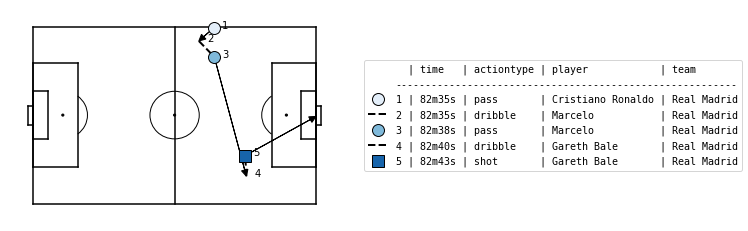

In [24]:
import matplotsoccer

# Select the 5 actions preceding the 2-0
shot = 1489
a = actions[shot-4:shot+1].copy()

# Print the game date and timestamp of the goal
#g = game.iloc[0]
#minute = int((a.period_id.values[0]-1) * 45 + a.time_seconds.values[0] // 60)
#game_info = f"{g.game_date} {g.home_team_name} {g.home_score}-{g.away_score} {g.away_team_name} {minute + 1}'"
#print(game_info)

# Plot the actions
def nice_time(row):
    minute = int((row.period_id-1)*45 +row.time_seconds // 60)
    second = int(row.time_seconds % 60)
    return f"{minute}m{second}s"

a["nice_time"] = a.apply(nice_time, axis=1)
labels = a[["nice_time", "type_name", "player_name", "team_name"]]

ax = matplotsoccer.actions(
    location=a[["start_x", "start_y", "end_x", "end_y"]],
    action_type=a.type_name,
    team= a.team_name,
    result= a.result_name == "success",
    label=labels,
    labeltitle=["time", "actiontype", "player", "team"],
    zoom=False,
    figsize=6
)